In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
from torch_geometric.loader import DataLoader
import torch

/data/conghao001/anaconda3/envs/gnndrug/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from utils_data import TestbedDataset

In [4]:
device = torch.device("cuda:3")
# device = torch.device("cpu")
device

device(type='cuda', index=3)

In [53]:
from models import GATNet_E, GATNet, GATv2Net
# model = GATNet_E()
# model_path = 'root_folder/root_010/models/model_GAT_Edge-EP300-SW801010_GDSC.model'
model = GATNet()
model_path = 'root_folder/root_010/models/model_GAT-EP300-SW801010_GDSC.model'

# both state dict and model need to be moved to cuda manually 
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

GATNet(
  (gcn1): GATConv(270, 270, heads=10)
  (gcn2): GATConv(2700, 128, heads=1)
  (fc_g1): Linear(in_features=128, out_features=128, bias=True)
  (conv_xt_1): Conv1d(1, 32, kernel_size=(8,), stride=(1,))
  (pool_xt_1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_2): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
  (pool_xt_2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_3): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
  (pool_xt_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1_xt): Linear(in_features=2944, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
branch_folder = "root_folder/root_010"
dataset = 'GDSC'
test_data = TestbedDataset(root=branch_folder, dataset=dataset+'_test_mix')

Pre-processed data found: root_folder/root_010/processed/GDSC_test_mix.pt, loading ...


In [7]:
test_batch = 1
test_loader = DataLoader(test_data, batch_size=test_batch, shuffle=False)

## One instance

In [8]:
one = next(iter(test_loader))
one

DataBatch(x=[38, 270], edge_index=[2, 84], y=[1], edge_features=[84, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[38], ptr=[2])

In [54]:
data = one.to(device)
out, _, attn_weights = model(data.x, data.edge_index, data.target, data.batch, data.edge_features, return_attention_weights=True)

In [55]:
attn_weights

(tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,
           7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15,
          15, 16, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 22, 22, 22, 23,
          23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32,
          32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37,  0,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
          24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
         [ 1,  0,  2,  1,  3,  7,  2,  4, 28,  3,  5,  4,  6, 11,  5,  7,  8,  6,
           2,  6,  9, 12,  8, 10,  9, 11, 10,  5,  8, 13, 12, 14, 18, 13, 15, 14,
          16, 15, 17, 19, 16, 18, 17, 13, 16, 20, 19, 21, 22, 20, 20, 23, 27, 22,
          24, 23, 25, 24, 26, 25, 27, 26, 22,  3, 29, 28, 30, 29, 31, 30, 32, 31,
          33, 37, 32, 34, 33, 35, 34, 36, 35, 37, 36, 32,  0,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 1

In [56]:
attn_weights = attn_weights[1].to('cpu').detach().numpy()
attn_weights.shape

(122, 1)

In [12]:
attn_weights = attn_weights[:-38, ]
attn_weights.shape

(84, 1)

In [24]:
attn_weights.shape[0]/2

42.0

In [31]:
agg_attn_weights = np.zeros(int(attn_weights.shape[0]/2))
for i in range(0, agg_attn_weights.shape[0]):
#     print(i)
    agg_attn_weights[i] = attn_weights[2*i] + attn_weights[2*i+1]

In [32]:
agg_attn_weights

array([0.83836603, 0.68224132, 0.57575345, 0.56296712, 0.47980446,
       0.56345797, 0.51925766, 0.66844475, 0.3960565 , 0.43968996,
       0.60726154, 0.60407007, 0.76538956, 0.48325482, 0.63339305,
       0.65829194, 0.51235408, 0.67246878, 0.57499248, 0.7112574 ,
       0.52736682, 0.61516535, 0.59858894, 0.97885162, 0.51317298,
       0.53097403, 0.4695977 , 0.69772983, 0.7099576 , 0.66135931,
       0.69097978, 0.57471597, 0.67942214, 0.71030951, 0.68201494,
       0.57855797, 0.7291314 , 0.70240974, 0.75759953, 0.59494597,
       0.53555632, 0.52739334])

In [33]:
# this is to normalize the array to a unit vector

# norm = np.linalg.norm(agg_attn_weights)
# norm_attn_weights = agg_attn_weights / norm
# norm_attn_weights

array([0.20559187, 0.16730553, 0.14119159, 0.138056  , 0.11766209,
       0.13817637, 0.12733717, 0.1639222 , 0.09712464, 0.10782484,
       0.14891829, 0.14813565, 0.18769591, 0.11850822, 0.1553265 ,
       0.16143244, 0.12564421, 0.16490901, 0.14100497, 0.17442112,
       0.12932577, 0.15085654, 0.14679152, 0.24004305, 0.12584503,
       0.13021036, 0.11515909, 0.17110376, 0.17410237, 0.16218465,
       0.16944845, 0.14093717, 0.16661418, 0.17418867, 0.16725001,
       0.14187934, 0.17880435, 0.17225141, 0.18578556, 0.14589815,
       0.13133407, 0.12933227])

In [37]:
norm_attn_weights = (agg_attn_weights - agg_attn_weights.min()) /(agg_attn_weights.max() - agg_attn_weights.min())
norm_attn_weights = norm_attn_weights.round(2)
norm_attn_weights

array([0.76, 0.49, 0.31, 0.29, 0.14, 0.29, 0.21, 0.47, 0.  , 0.07, 0.36,
       0.36, 0.63, 0.15, 0.41, 0.45, 0.2 , 0.47, 0.31, 0.54, 0.23, 0.38,
       0.35, 1.  , 0.2 , 0.23, 0.13, 0.52, 0.54, 0.46, 0.51, 0.31, 0.49,
       0.54, 0.49, 0.31, 0.57, 0.53, 0.62, 0.34, 0.24, 0.23])

In [13]:
data.edge_index

tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,
          7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15,
         15, 16, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 22, 22, 22, 23,
         23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32,
         32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37],
        [ 1,  0,  2,  1,  3,  7,  2,  4, 28,  3,  5,  4,  6, 11,  5,  7,  8,  6,
          2,  6,  9, 12,  8, 10,  9, 11, 10,  5,  8, 13, 12, 14, 18, 13, 15, 14,
         16, 15, 17, 19, 16, 18, 17, 13, 16, 20, 19, 21, 22, 20, 20, 23, 27, 22,
         24, 23, 25, 24, 26, 25, 27, 26, 22,  3, 29, 28, 30, 29, 31, 30, 32, 31,
         33, 37, 32, 34, 33, 35, 34, 36, 35, 37, 36, 32]], device='cuda:3')

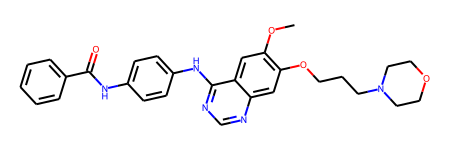

In [15]:
mol = Chem.MolFromSmiles(data.smiles[0])
mol

In [16]:
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

0 1
1 2
2 3
3 4
4 5
5 6
6 7
6 8
8 9
9 10
10 11
8 12
12 13
13 14
14 15
15 16
16 17
17 18
16 19
19 20
20 21
20 22
22 23
23 24
24 25
25 26
26 27
3 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
7 2
11 5
18 13
27 22
37 32


In [40]:
for i, bond in enumerate(mol.GetBonds()):
#     weight = attn_weights[2*i] + attn_weights[2*i+1]
#     print(i, weight)
    bond.SetProp('bondNote',str(norm_attn_weights[i]))

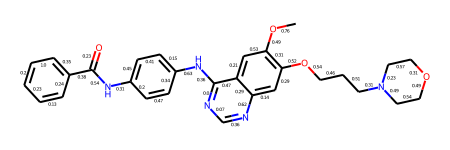

In [41]:
mol

## All drugs

In [44]:
import os
d_save_path = 'root_folder/root_010/SaliencyMap/Bonds/GAT_Edge/'
os.makedirs(d_save_path, exist_ok=True)

In [47]:
for idx, data in enumerate(test_loader):
    data = data.to(device)
    drug = data.drug_name[0]
    cell_line = data.cell_line_name[0]
    filename = drug + '_' + cell_line +'.png'
    print(idx, drug, cell_line)
    
    out, _, attn_weights = model(data.x, data.edge_index, data.target, data.batch, data.edge_features, return_attention_weights=True)    
    attn_weights = attn_weights[1].to('cpu').detach().numpy()
    attn_weights = attn_weights[:-data.x.shape[0], ]
    
    agg_attn_weights = np.zeros(int(attn_weights.shape[0]/2))
    for i in range(0, agg_attn_weights.shape[0]):
        agg_attn_weights[i] = attn_weights[2*i] + attn_weights[2*i+1]
    norm_attn_weights = (agg_attn_weights - agg_attn_weights.min()) /(agg_attn_weights.max() - agg_attn_weights.min())
    norm_attn_weights = norm_attn_weights.round(2)
    
    mol = Chem.MolFromSmiles(data.smiles[0])
    for i, bond in enumerate(mol.GetBonds()):
        bond.SetProp('bondNote',str(norm_attn_weights[i]))
        
    Chem.Draw.MolToImageFile(mol, d_save_path + filename, size = (1000, 1000))

0 ZM447439 910944
1 PLX-4720 905978
2 VX-11e 924238
3 Temozolomide 946360
4 Gefitinib 908465
5 VX-11e 1290797
6 OSI-027 907056
7 Talazoparib 908129
8 Docetaxel 908148
9 WIKI4 1503370
10 Gefitinib 909723
11 YK-4-279 909773
12 Rapamycin 1290455
13 Daporinad 910548
14 OSI-027 722066
15 Axitinib 905989
16 Gemcitabine 909249
17 Pictilisib 908471
18 Trametinib 907295
19 Camptothecin 724878
20 I-BET-762 907789
21 SB216763 753612
22 AZD7762 1240199
23 Navitoclax 753541
24 JQ1 1303900
25 Obatoclax Mesylate 910926
26 PLX-4720 1240166
27 Nutlin-3a (-) 1503371
28 Obatoclax Mesylate 753552
29 BMS-345541 688001
30 Vinblastine 1298146
31 WIKI4 1322224
32 Sepantronium bromide 908120
33 Pictilisib 924186
34 BI-2536 910942
35 PD0325901 909260
36 Navitoclax 1303900
37 RO-3306 1303912
38 Palbociclib 1290908
39 Gemcitabine 1240123
40 YK-4-279 905947
41 BMS-345541 910689
42 PLX-4720 906838
43 Tamoxifen 907276
44 Tozasertib 753594
45 VX-11e 909740
46 PD0325901 910921
47 5-Fluorouracil 1660034
48 Sepantronium

390 Olaparib 924100
391 Entinostat 1298352
392 VX-11e 1247873
393 Pictilisib 1295741
394 Talazoparib 753614
395 PLX-4720 1298533
396 JQ1 906795
397 Dabrafenib 753618
398 JQ1 753556
399 GSK1904529A 910710
400 Axitinib 1503364
401 AZD7762 753554
402 Dabrafenib 906793
403 Crizotinib 753612
404 Bortezomib 687807
405 Ruxolitinib 753589
406 AZD8055 1299050
407 5-Fluorouracil 1240196
408 Dactolisib 909759
409 Daporinad 905964
410 Dactolisib 1330947
411 Vorinostat 687997
412 PF-4708671 1331033
413 Olaparib 688013
414 Nutlin-3a (-) 753554
415 Nilotinib 1298359
416 Gefitinib 906852
417 MK-2206 909780
418 Dactolisib 1298151
419 AZD8055 906862
420 Pictilisib 905977
421 BI-2536 735784
422 PD0325901 949171
423 Ruxolitinib 905977
424 PLX-4720 910900
425 Nutlin-3a (-) 1479987
426 RO-3306 1331038
427 Axitinib 1240154
428 Daporinad 907055
429 Vinblastine 753554
430 YK-4-279 753618
431 Navitoclax 1331038
432 Rapamycin 917486
433 Talazoparib 909704
434 AZD6482 1330935
435 YK-4-279 909249
436 Paclitaxel 91

772 Vorinostat 905964
773 Daporinad 908461
774 PD173074 909751
775 MK-2206 749710
776 NU7441 905964
777 ZM447439 1240121
778 PF-4708671 687787
779 ZM447439 907055
780 BMS-536924 907046
781 JQ1 1240212
782 GSK269962A 949090
783 JQ1 910687
784 ZM447439 907047
785 Gemcitabine 907170
786 Tamoxifen 905983
787 Olaparib 905976
788 PF-4708671 1503365
789 Obatoclax Mesylate 909781
790 Linsitinib 1290813
791 AZD7762 687514
792 PD0325901 687985
793 SB216763 905973
794 BMS-536924 909250
795 PF-4708671 909745
796 Luminespib 906836
797 Doramapimod 905980
798 BMS-536924 905957
799 Dasatinib 687807
800 Sepantronium bromide 908158
801 PD173074 1240173
802 Dasatinib 907278
803 RO-3306 905965
804 Sepantronium bromide 1503365
805 Camptothecin 998184
806 Vinblastine 925347
807 Sepantronium bromide 910546
808 Vorinostat 910706
809 Trametinib 1503371
810 GSK269962A 946368
811 Afatinib 905978
812 Olaparib 949168
813 GSK269962A 724825
814 BMS-754807 910784
815 Palbociclib 909260
816 BMS-536924 905940
817 MK-22

1148 PLX-4720 905944
1149 Linsitinib 908123
1150 Gemcitabine 1290813
1151 Olaparib 907068
1152 Luminespib 906797
1153 KU-55933 907285
1154 XAV939 1240149
1155 Tamoxifen 910694
1156 Gemcitabine 1290810
1157 JQ1 1240162
1158 Ruxolitinib 753558
1159 AZD6482 925343
1160 Palbociclib 687820
1161 JQ1 1240122
1162 Linsitinib 687995
1163 Trametinib 907061
1164 Cytarabine 908476
1165 GSK269962A 909759
1166 Sepantronium bromide 908473
1167 GSK1904529A 753586
1168 Docetaxel 688018
1169 Entinostat 905978
1170 Gemcitabine 910915
1171 Olaparib 1330983
1172 Dactolisib 1240197
1173 XAV939 1322224
1174 Trametinib 908126
1175 WIKI4 930298
1176 Talazoparib 1290809
1177 Vinblastine 905957
1178 Olaparib 908144
1179 Obatoclax Mesylate 906826
1180 GSK269962A 1789883
1181 PF-4708671 949153
1182 Afatinib 722066
1183 Olaparib 724872
1184 Temozolomide 910907
1185 KU-55933 687807
1186 5-Fluorouracil 905991
1187 Bortezomib 909723
1188 Sepantronium bromide 1298352
1189 BI-2536 909777
1190 Gefitinib 907783
1191 BMS-5

1513 BI-2536 1330972
1514 Doramapimod 907057
1515 YK-4-279 1322224
1516 Dasatinib 924239
1517 Dabrafenib 907053
1518 PLX-4720 1240173
1519 I-BET-762 906693
1520 Ruxolitinib 905948
1521 5-Fluorouracil 911905
1522 Nutlin-3a (-) 1322224
1523 AZD6482 1240222
1524 Olaparib 753615
1525 Palbociclib 907055
1526 Ruxolitinib 907272
1527 OSI-027 910921
1528 Afatinib 907062
1529 BI-2536 905942
1530 Afatinib 909716
1531 Entinostat 908150
1532 Doramapimod 687590
1533 Afatinib 724870
1534 Navitoclax 946370
1535 AZD6482 908457
1536 Olaparib 909744
1537 VX-11e 907323
1538 Bortezomib 687448
1539 NU7441 1503367
1540 Gefitinib 906837
1541 NU7441 906865
1542 Gefitinib 930298
1543 Olaparib 717431
1544 PD0325901 1299078
1545 Rapamycin 946355
1546 BMS-754807 909977
1547 Lapatinib 905952
1548 GSK1904529A 753551
1549 Lapatinib 910943
1550 JQ1 1298134
1551 Afatinib 907061
1552 Sorafenib 905989
1553 Luminespib 907789
1554 Sepantronium bromide 1290455
1555 GSK269962A 946355
1556 RO-3306 905960
1557 Tamoxifen 68802

1879 BMS-536924 908458
1880 AZD6482 924102
1881 Tamoxifen 910850
1882 Trametinib 907792
1883 GSK269962A 908447
1884 Sepantronium bromide 910554
1885 Docetaxel 907312
1886 Afatinib 906808
1887 GSK1904529A 905986
1888 5-Fluorouracil 1240143
1889 Vorinostat 908136
1890 Sepantronium bromide 906855
1891 Pictilisib 908457
1892 Camptothecin 687586
1893 Lapatinib 688001
1894 Cytarabine 907065
1895 AZD8055 909770
1896 GSK269962A 908126
1897 PF-4708671 906827
1898 GSK269962A 909250
1899 AZD8055 1298534
1900 Entinostat 909723
1901 Pevonedistat 905973
1902 Pictilisib 908123
1903 ZM447439 724855
1904 Vorinostat 753539
1905 Rapamycin 753548
1906 BMS-536924 688018
1907 MK-2206 924110
1908 JQ1 910952
1909 Luminespib 906832
1910 Pictilisib 907170
1911 BMS-345541 910710
1912 NU7441 1297446
1913 OSI-027 924110
1914 AZD6482 687997
1915 Luminespib 906844
1916 5-Fluorouracil 908454
1917 BMS-345541 1331032
1918 Talazoparib 910568
1919 Dabrafenib 909743
1920 Afatinib 909759
1921 Daporinad 1298169
1922 RO-3306

2244 AZD8055 909252
2245 KU-55933 908132
2246 Gefitinib 907791
2247 Linsitinib 909759
2248 Linsitinib 910694
2249 Navitoclax 924110
2250 GSK269962A 909251
2251 BMS-754807 1240217
2252 PLX-4720 908454
2253 AZD8055 1240168
2254 Gemcitabine 1240154
2255 BI-2536 1331040
2256 RO-3306 1330931
2257 Gemcitabine 753572
2258 5-Fluorouracil 687588
2259 NU7441 908131
2260 Nutlin-3a (-) 1503361
2261 YK-4-279 1240174
2262 RO-3306 753621
2263 BI-2536 906875
2264 PD173074 753538
2265 Dactolisib 687995
2266 Vinblastine 907065
2267 AZD7762 917486
2268 AZD7762 1240127
2269 Entinostat 905965
2270 Gemcitabine 910852
2271 YK-4-279 1327766
2272 MK-2206 910688
2273 BMS-754807 688027
2274 PLX-4720 1298359
2275 YK-4-279 909720
2276 Afatinib 1503362
2277 Sepantronium bromide 907064
2278 YK-4-279 909252
2279 WIKI4 1298359
2280 Paclitaxel 910706
2281 AZD7762 1290769
2282 YK-4-279 908444
2283 KU-55933 910920
2284 AZD7762 909725
2285 GSK269962A 1290922
2286 Afatinib 910568
2287 Gemcitabine 910694
2288 PD0325901 9109

2612 KU-55933 1240198
2613 Entinostat 924110
2614 5-Fluorouracil 924151
2615 Sepantronium bromide 905975
2616 Afatinib 909698
2617 I-BET-762 911905
2618 VX-11e 753554
2619 Dabrafenib 753555
2620 Olaparib 687448
2621 ZM447439 687820
2622 WIKI4 724855
2623 Vorinostat 1247873
2624 BMS-345541 1240192
2625 AZD6482 909770
2626 JQ1 1240155
2627 Axitinib 687586
2628 JQ1 905956
2629 BMS-536924 907322
2630 Axitinib 1240215
2631 OSI-027 907280
2632 I-BET-762 1240184
2633 I-BET-762 907170
2634 Dactolisib 910694
2635 Camptothecin 906835
2636 JQ1 907322
2637 Gemcitabine 908120
2638 PD0325901 1240128
2639 Vinblastine 1240162
2640 Cytarabine 909738
2641 Olaparib 1290922
2642 Pevonedistat 910944
2643 Olaparib 907789
2644 OSI-027 1503366
2645 Navitoclax 908483
2646 Vinblastine 687506
2647 Olaparib 1330993
2648 SB216763 1298349
2649 I-BET-762 908462
2650 Afatinib 906800
2651 BMS-345541 753586
2652 XAV939 907312
2653 JQ1 907000
2654 PLX-4720 908130
2655 XAV939 907173
2656 GSK1904529A 1240122
2657 PLX-4720

2981 BMS-536924 924240
2982 Olaparib 753610
2983 Gemcitabine 910924
2984 Palbociclib 909708
2985 AZD6482 949156
2986 Talazoparib 907269
2987 BMS-345541 910706
2988 PD173074 1240212
2989 Vinblastine 906693
2990 PLX-4720 1240157
2991 AZD8055 1509073
2992 Gefitinib 905989
2993 WIKI4 909781
2994 Dactolisib 1299062
2995 Dabrafenib 906856
2996 Dabrafenib 908442
2997 Dabrafenib 908136
2998 Dabrafenib 1240198
2999 BMS-754807 905947
3000 Sepantronium bromide 687780
3001 Crizotinib 753532
3002 5-Fluorouracil 1298365
3003 Luminespib 1298357
3004 5-Fluorouracil 687820
3005 Linsitinib 908121
3006 BMS-536924 753612
3007 Rapamycin 753616
3008 Dactolisib 949090
3009 Docetaxel 1240170
3010 MK-2206 910687
3011 ZM447439 949177
3012 5-Fluorouracil 687798
3013 AZD6482 1290798
3014 Paclitaxel 688001
3015 XAV939 910903
3016 Dabrafenib 924102
3017 Sepantronium bromide 910703
3018 I-BET-762 1240170
3019 Olaparib 908460
3020 PD0325901 909757
3021 Obatoclax Mesylate 909708
3022 WIKI4 910568
3023 I-BET-762 908448

3344 Daporinad 905937
3345 YK-4-279 924100
3346 PD173074 906826
3347 Luminespib 907312
3348 Vinblastine 909905
3349 Dasatinib 1303897
3350 Pictilisib 909252
3351 Paclitaxel 909769
3352 RO-3306 749715
3353 Docetaxel 908143
3354 Linsitinib 905955
3355 Docetaxel 1240183
3356 Entinostat 753585
3357 Axitinib 908443
3358 VX-11e 930298
3359 AZD7762 753616
3360 Nilotinib 907792
3361 PLX-4720 909784
3362 AZD6482 906865
3363 Olaparib 907060
3364 VX-11e 909977
3365 Dabrafenib 1240210
3366 Docetaxel 1290797
3367 MK-2206 1298359
3368 Trametinib 909696
3369 BMS-754807 1298529
3370 Olaparib 908136
3371 5-Fluorouracil 1240183
3372 PLX-4720 1240146
3373 Afatinib 1240202
3374 VX-11e 907298
3375 PD0325901 909904
3376 GSK269962A 1299070
3377 Olaparib 930083
3378 Cytarabine 1240154
3379 WIKI4 1240218
3380 ZM447439 909701
3381 AZD6482 906849
3382 Navitoclax 906844
3383 GSK269962A 910853
3384 OSI-027 684059
3385 Talazoparib 906795
3386 Navitoclax 749716
3387 YK-4-279 753621
3388 Axitinib 687807
3389 Tozasert

3710 Obatoclax Mesylate 949094
3711 BMS-345541 949094
3712 NU7441 909702
3713 Afatinib 910852
3714 GSK269962A 949158
3715 Gefitinib 909728
3716 5-Fluorouracil 724873
3717 NU7441 687505
3718 Nilotinib 684057
3719 Vinblastine 1290906
3720 Navitoclax 910780
3721 BMS-536924 1298352
3722 JQ1 1298222
3723 GSK269962A 906833
3724 AZD7762 749717
3725 Dabrafenib 753575
3726 Sepantronium bromide 907280
3727 5-Fluorouracil 1240216
3728 PF-4708671 946358
3729 Talazoparib 908476
3730 Axitinib 908134
3731 Daporinad 906868
3732 GSK269962A 905976
3733 Trametinib 906846
3734 AZD6482 1240147
3735 Tozasertib 906800
3736 Cytarabine 908146
3737 ZM447439 1240153
3738 Axitinib 687819
3739 Pictilisib 907270
3740 Doramapimod 1247871
3741 Linsitinib 753547
3742 JQ1 907792
3743 Afatinib 908149
3744 Ruxolitinib 906828
3745 Pevonedistat 946358
3746 Olaparib 753610
3747 Afatinib 749714
3748 AZD8055 753562
3749 Sepantronium bromide 1298475
3750 Gefitinib 1297449
3751 Tamoxifen 949172
3752 Afatinib 908121
3753 Crizoti

4073 RO-3306 1240145
4074 RO-3306 905974
4075 Sepantronium bromide 906851
4076 Camptothecin 908467
4077 5-Fluorouracil 908127
4078 Paclitaxel 688025
4079 RO-3306 1290771
4080 Docetaxel 1298216
4081 Sepantronium bromide 907795
4082 VX-11e 905971
4083 Pictilisib 908483
4084 RO-3306 905957
4085 Ruxolitinib 910911
4086 Vorinostat 906875
4087 Docetaxel 907298
4088 GSK269962A 910703
4089 NU7441 910687
4090 Luminespib 906873
4091 Afatinib 753565
4092 Daporinad 1298222
4093 Linsitinib 909709
4094 GSK1904529A 910944
4095 AZD6482 724868
4096 ZM447439 1330947
4097 Dabrafenib 687820
4098 Sorafenib 910942
4099 Ruxolitinib 753575
4100 Luminespib 1330933
4101 Axitinib 906861
4102 I-BET-762 1503361
4103 Luminespib 907064
4104 BMS-754807 910905
4105 ZM447439 1298219
4106 AZD7762 907286
4107 PD173074 906821
4108 Gefitinib 749714
4109 Ruxolitinib 1240181
4110 JQ1 924108
4111 Navitoclax 1290798
4112 Trametinib 753584
4113 YK-4-279 1524416
4114 Pictilisib 1789883
4115 Dabrafenib 905968
4116 5-Fluorouracil 

4438 AZD6482 1330942
4439 Cytarabine 907000
4440 Gemcitabine 909699
4441 Vorinostat 753583
4442 PD0325901 906871
4443 Dactolisib 749714
4444 Navitoclax 908446
4445 Afatinib 1299081
4446 BMS-345541 905959
4447 Docetaxel 907275
4448 XAV939 905938
4449 VX-11e 949094
4450 Axitinib 1298538
4451 MK-2206 1297439
4452 GSK269962A 906856
4453 Obatoclax Mesylate 905961
4454 AZD6482 906861
4455 Gefitinib 1240226
4456 Talazoparib 906818
4457 Pictilisib 909263
4458 Cytarabine 1240168
4459 Docetaxel 910079
4460 MK-2206 949172
4461 BMS-754807 905973
4462 KU-55933 687568
4463 I-BET-762 909713
4464 BMS-536924 753594
4465 XAV939 1322212
4466 Gemcitabine 1240121
4467 AZD6482 1298347
4468 Entinostat 908146
4469 PLX-4720 1303900
4470 AZD8055 905961
4471 AZD7762 909251
4472 Temozolomide 1240208
4473 OSI-027 906790
4474 BMS-345541 687821
4475 ZM447439 908149
4476 BMS-754807 909785
4477 NU7441 908159
4478 Cytarabine 753615
4479 Trametinib 908151
4480 OSI-027 1240190
4481 Axitinib 905939
4482 Pevonedistat 68801

4805 BMS-345541 1240174
4806 XAV939 906795
4807 BMS-754807 1298169
4808 MK-2206 924105
4809 Axitinib 906844
4810 YK-4-279 1240121
4811 Navitoclax 906868
4812 PD173074 909716
4813 KU-55933 905941
4814 BMS-536924 909748
4815 5-Fluorouracil 905939
4816 Dactolisib 949157
4817 Dabrafenib 906765
4818 Olaparib 907046
4819 KU-55933 949161
4820 Olaparib 910689
4821 Olaparib 1290905
4822 BMS-345541 909731
4823 Luminespib 724828
4824 OSI-027 907060
4825 Palbociclib 907317
4826 AZD7762 1330985
